In [273]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [356]:
## Comment in this script is follwoing doxygen style in case it is needed to export in Latex. ref: https://www.doxygen.nl/manual/docblocks.html#pythonblocks
## general path config
gen_path = '/content/drive/MyDrive/Job'
proj_name = 'Fracta_test'
proj_path = os.path.join(gen_path, proj_name) # current location
plot_path = os.path.join(proj_path, 'plots') # plot output for EDA
data_path = os.path.join(proj_path, 'data') # raw data path

# GM Data loading

In [357]:
## load data
gm_name = 'GM2022_assets.csv'
gm_path = os.path.join(data_path, gm_name)
gm_df = pd.read_csv(gm_path, encoding = "cp932") # encoding option for reading Japanese. ref: https://docs.python.org/3/library/codecs.html#standard-encodings

## Check data shape
print(gm_df.head().to_markdown(index=False, numalign="left", stralign="left"))
print(gm_df.info())
print('# of duplicated rows:', gm_df.duplicated().sum())

| GID       | 管種   | 埋設年   | Shape_LENGTH   | 口径   | 活用状況   | soil_ph   | mean_low_temp   | soil_moisture_index   |
|:----------|:-------|:---------|:---------------|:-------|:-----------|:----------|:----------------|:----------------------|
| WM09952-D | DUC(K) | S63.12   | 24.6183        | 10     | True       | 7.60746   | 4.92414         | 6.35588               |
| WM02595-P | CIP    | S29.7    | 514.016        | 10     | True       | 7.99887   | 5.73829         | 7.58934               |
| WM04638-C | CIP    | S11.1    | 447.748        | 6      | True       | 8.27867   | 5.19317         | 5.6778                |
| WM02974-D | DUC(G) | S55.2    | 120.439        | 14     | True       | 6.40976   | 6.15492         | 3.54707               |
| WM08449-D | DUC(K) | H28.9    | 0.0186696      | 10     | True       | 7.11469   | 8.41889         | 4.16761               |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 9 columns):
 #   Column     

# GM Data Cleaning

# Rename column name to English

| Japanese | English |
| :-: | :-: |
| GID | native_pipe_id |
| 管種 | material_original |
| 埋設年 | install_year_original |
| 口径 | diameter |
| 活用状況 | usage_status |

This is unnecessary step. It is done for consistancy of the table.

The `管種` is named to `material_original`. The Fracta standard name will be saved in `material` after the conversion based on the instruction.

The `埋設年` is calculated in Japanese era standard. I named to `install_year_original` in order to save the converted Gregorian version as a `install_year`.

In [358]:
## rename column name to english
## this is unnecessary step. It is done for consistancy of the table
col_dict = {'GID':'native_pipe_id', '管種':'material_original',
            '埋設年':'install_year_original', '口径':'diameter', '活用状況':'usage_status'}
gm_df.rename(columns = col_dict, inplace = True)
gm_df.columns = map(str.lower, gm_df.columns) # little bit of consistancy

## check the rename results
print(gm_df.columns)

Index(['native_pipe_id', 'material_original', 'install_year_original',
       'shape_length', 'diameter', 'usage_status', 'soil_ph', 'mean_low_temp',
       'soil_moisture_index'],
      dtype='object')


# Required cleaning

1. The `usage_status` (活用状況) is oppsite to the `abandoned` (撤去ステータス). I flipped the boolean to create the `abandoned`
2. The 管種 information in the `material_original` is renamed to following the Fracta standard and saved in the `material`.

| material_original | material | full name |
| :-: | :-: | :-: |
| DUC(K), DUC(G) | DIP | Ductile Cast Iron Pipe |
| CIP | CAS | Gray Cast Iron Pipe |
| PVC | PVC | Polyvinyl Chloride Pipe |
| ACON | AC | Asbestos Cement Pipe |
| STW, STP | SP | Steel Pipe |

3. The Japanese era in `install_year_original` is converted to Gregorians style by `jp_to_gr()` and saved in `install_year`.

# Additional engineering

1. Since information in `material_original`, `material`, and `native_pipe_id` are non-numerical format, It is not applicable for the merchine leraning process. Both columns are converted to numerical format by `LabelEncoder()` and saved in `material_original_encode`, `material_encode`, and `native_pipe_id_encode` in case it needed for ML. The `material_original_encode` is also changed this in case differences between 'DUC(G)' and 'DUC(K)' are needed to be considered.


In [359]:
## converts usage status (活用状況) to abandoned (撤去ステータス)
## Since the usage status is oppsite of the abandoned, It might not need to keep it in the table
gm_df['abandoned'] = ~gm_df['usage_status']

## Rename material to company standard
mat_dict = {'DUC(K)':'DIP', 'DUC(G)':'DIP', 'CIP':'CAS', 'PVC':'PVC', 'ACON':'AC', 'STW':'SP', 'STP':'SP'}
gm_df['material'] = gm_df['material_original'].map(mat_dict)
"""
## alternate way to convert material names by using NumPy functions and not using the for loop
old_mat_name = np.array(['ACON', 'CIP', 'DUC(G)', 'DUC(K)', 'PVC', 'STP', 'STW'], dtype = 'object')
new_mat_name = np.array(['AC', 'CAS', 'DIP', 'DIP', 'PVC', 'SP', 'SP'], dtype = 'object')
mat_ori_np = gm_df['material_original'].to_numpy(dtype = 'object')
mat_ori_idx = np.searchsorted(old_mat_name, mat_ori_np, side = 'left')
gm_df['material'] = new_mat_name[mat_ori_idx]
"""

## converts Japanese years to Gregorians
def jp_to_gr(jp_dt):
  jp_yr_dict = {'M':1867, 'T':1911, 'S':1925, 'H':1988, 'R':2018}

  #if type(jp_dt) == float: return 'NULL' # Not sure whether the instruction want me to convert to NaN (or None) or literal 'NULL'
  if type(jp_dt) == float: return np.nan # I will turn it to 'NULL' after EDA or ML
  jp_yr, mon = jp_dt.split('.') # There is no date information in the raw data
  gr_yr = int(jp_yr[1:]) + jp_yr_dict[jp_yr[:1]] - 1

  return f'{gr_yr:04d}-{int(mon):02d}-01' # simpler return than using datetime package
  #return datetime.date(gr_yr, int(mon), 1).strftime('%Y-%m-%d')
  ## we can also use '!pip install Japanera' for the conversion
gm_df['install_year'] = gm_df['install_year_original'].apply(jp_to_gr)

## converts material & material_original to numerical formats in case it needed for ML
label_encoder = LabelEncoder()
gm_df['material_original_encode'] = label_encoder.fit_transform(gm_df['material_original']) # I changed this too in case differences between 'DUC(G)' and 'DUC(K)' are needed to be considered
gm_df['material_encode'] = label_encoder.fit_transform(gm_df['material'])
gm_df['native_pipe_id_encode'] = label_encoder.fit_transform(gm_df['native_pipe_id'])

## middle check
gm_df.head()

,native_pipe_id,material_original,install_year_original,shape_length,diameter,usage_status,soil_ph,mean_low_temp,soil_moisture_index,abandoned,material,install_year,material_original_encode,material_encode,native_pipe_id_encode
0,WM09952-D,DUC(K),S63.12,24.618317,10.0,True,7.607464,4.924143,6.355882,False,DIP,1987-12-01,3,2,6125
1,WM02595-P,CIP,S29.7,514.015780,10.0,True,7.998868,5.738295,7.589341,False,CAS,1953-07-01,1,1,1564
2,WM04638-C,CIP,S11.1,447.747983,6.0,True,8.278671,5.193168,5.677802,False,CAS,1935-01-01,1,1,2780
3,WM02974-D,DUC(G),S55.2,120.438646,14.0,True,6.409756,6.154922,3.547069,False,DIP,1979-02-01,2,2,1788
4,WM08449-D,DUC(K),H28.9,0.018670,10.0,True,7.114687,8.418888,4.167609,False,DIP,2015-09-01,3,2,5157


# WO Data Loading

In [360]:
## load data
wo_name = 'WO_EXPORT.csv'
wo_path = os.path.join(data_path, wo_name)
wo_df = pd.read_csv(wo_path, encoding = "cp932") # encoding option for reading Japanese. ref: https://docs.python.org/3/library/codecs.html#standard-encodings

## Check data shape
print(wo_df.head().to_markdown(index=False, numalign="left", stralign="left"))
print(wo_df.info())
print('# of duplicated rows:', wo_df.duplicated().sum())

| 紐づけ管路ID   | 漏水項目              | 修繕結果   | RMINFO   | 受付日      | 登録日   |
|:---------------|:----------------------|:-----------|:---------|:------------|:---------|
| WM02656-C      | 亀裂                  | Resolved   | 1        | 2.00209e+07 | 20221114 |
| WM04742-P      | 第三者損傷            | Resolved   | 1        | 2.02106e+07 | 20221114 |
| WM00040-C      | 亀裂                  | Resolved   | 0        | 2.01306e+07 | 20221114 |
| WM12614-C      | ピンホール（5mm以下） | Resolved   | 0        | 2.00805e+07 | 20221114 |
| WM04879-A      | 亀裂                  | Resolved   | 1        | 2.01504e+07 | 20221114 |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   紐づけ管路ID  340 non-null    object 
 1   漏水項目     333 non-null    object 
 2   修繕結果     340 non-null    object 
 3   RMINFO   340 non-null    int64  
 4   受付日      311 non-null    float64
 5   登録日      340 non-nul

# WO Data Cleaning

# Rename column name to English

| Japanese | English |
| :-: | :-: |
| 紐づけ管路ID | native_pipe_id |
| 漏水項目 | leaking_items_original |
| 修繕結果 | repair_results |
| 受付日 | receipt_date |
| 登録日 | registration_date_original |

This is unnecessary step. It is done for consistancy of the table.

The `漏水項目` is named to `leaking_items_original`. The information in the `leaking_items_original` is written in the Japanese. I translated them into the English and saved in `leaking_items`

The `登録日` is written in the int64 datatype. It is converted to data time with string format and saved in `registration_date`.

In [361]:
## rename column name to english
## this is unnecessary step. It is done for consistancy of the table
col_dict = {'紐づけ管路ID':'native_pipe_id', '漏水項目':'leaking_items_original',
            '修繕結果':'repair_results', '受付日':'receipt_date', '登録日':'registration_date_original'}
wo_df.rename(columns = col_dict, inplace = True)
wo_df.columns = map(str.lower, wo_df.columns) # little bit of consistancy

## check the rename results
print(wo_df.columns)

Index(['native_pipe_id', 'leaking_items_original', 'repair_results', 'rminfo',
       'receipt_date', 'registration_date_original'],
      dtype='object')


# Required cleaning

1. The `break_date` is calculated by converting `receipt_date` into date time strong format.
2. The incstuction mentioned the leakage incident should not include human-made leakage (漏水事故は自然に発生した漏水に絞る必要がある。). To take into account this, all the rows that corresponeded to `第三者損傷` needed to be removed from the table.
3. I will remove them after EDA or ML for reconstruction.

# Additional engineering

1. Japanese information in the `leaking_items_original` is traslated to the English and saved in `leaking_items`

| Japanese | English |
| :-: | :-: |
| 亀裂 | crack |
| 第三者損傷 | third_party_damage |
| ピンホール（5mm以下） | pinhole_less_than_5mm |
| 継手破損 | joint_damage |
| ピンホール（5mm以上） | pinhole_more_than_5mm |
| 不明 | unknown |


2. Since information in `leaking_items` and `repair_results` are non-numerical format, It is not applicable for the merchine leraning process. Both columns are converted to numerical format by `LabelEncoder()` and saved in `leaking_items_encode` and `repair_results_encode` in case it needed for ML.

3. The `registration_date_original` is written in the int64 datatype. It is converted to data time with string format and saved in `registration_date`.

In [362]:
## converts the receipt date (受付日) to break_date
nan_idx = np.isnan(wo_df['receipt_date'])
wo_df['break_date'] = pd.to_datetime(wo_df['receipt_date'], format='%Y%m%d').astype(str)
#wo_df['break_date'][nan_idx] = 'NULL' # I will turn it to 'NULL' after EDA or ML
wo_df['break_date'][nan_idx] = np.nan

## To follow this instruction, 漏水事故は自然に発生した漏水に絞る必要がある。(モデリングの観点からは、入力変数とターゲット変数の相関関係があるのが前提)。,
## All the rows that corresponeded to '第三者損傷':'third_party_damage' needed to be removed from the table.
## Let just keep the index of the 'third_party_damage' for now. I will remove them after EDA or ML for reconstruction
wo_tpd_idx = wo_df['leaking_items_original'] == '第三者損傷'

## converts leaking_items (漏水項目) to english and numerical format in case it needed for ML
item_dict = {'亀裂':'crack', '第三者損傷':'third_party_damage', 'ピンホール（5mm以下）':'pinhole_less_than_5mm',
            '継手破損':'joint_damage', 'ピンホール（5mm以上）':'pinhole_more_than_5mm', '不明':'unknown'}#, np.nan:'NULL'} # I will turn it to 'NULL' after EDA or ML
wo_df['leaking_items'] = wo_df['leaking_items_original'].map(item_dict)
wo_df['leaking_items_encode'] = label_encoder.fit_transform(wo_df['leaking_items'])

## converts repair_results (修繕結果) to numerical format in case it needed for ML
wo_df['repair_results_encode'] = label_encoder.fit_transform(wo_df['repair_results'])

## converts the registration date (登録日) to string format. Could converts to datetime format. Since break_date is string format, I will follow the string format
wo_df['registration_date'] = pd.to_datetime(wo_df['registration_date_original'], format='%Y%m%d').astype(str)

## middle check
wo_df.head()

<ipython-input-362-82a3b547a7c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_df['break_date'][nan_idx] = np.nan


,native_pipe_id,leaking_items_original,repair_results,rminfo,receipt_date,registration_date_original,break_date,leaking_items,leaking_items_encode,repair_results_encode,registration_date
0,WM02656-C,亀裂,Resolved,1,20020912.0,20221114,2002-09-12,crack,0,0,2022-11-14
1,WM04742-P,第三者損傷,Resolved,1,20210618.0,20221114,2021-06-18,third_party_damage,4,0,2022-11-14
2,WM00040-C,亀裂,Resolved,0,20130610.0,20221114,2013-06-10,crack,0,0,2022-11-14
3,WM12614-C,ピンホール（5mm以下）,Resolved,0,20080521.0,20221114,2008-05-21,pinhole_less_than_5mm,2,0,2022-11-14
4,WM04879-A,亀裂,Resolved,1,20150425.0,20221114,2015-04-25,crack,0,0,2022-11-14


# Exploratory data analysis (EDA) for sanity checking and filling missing data

# GM EDA

In [363]:
## new df for EDA
gm_eda_df = gm_df.copy()

## Converts 'install_year' to unixtime (timestamp) so that I can it for analysis as a numeric format. I din't consider the timezone
gm_eda_df['install_time_stamp'] = gm_eda_df['install_year'].apply(lambda x: pd.to_datetime(x).timestamp() if type(x) != float else np.nan)

## new df for missing spot ins the data
gm_time_eda_df = gm_eda_df[gm_eda_df['install_time_stamp'].isna()]
gm_dia_eda_df = gm_eda_df[gm_eda_df['diameter'].isna()]

## check the shape time should be all nan on `gm_time_eda_df` and diameter should be all nan on `gm_dia_eda_df`
print(gm_time_eda_df.info(), gm_dia_eda_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 63 to 9857
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   native_pipe_id            267 non-null    object 
 1   material_original         267 non-null    object 
 2   install_year_original     0 non-null      object 
 3   shape_length              267 non-null    float64
 4   diameter                  260 non-null    float64
 5   usage_status              267 non-null    bool   
 6   soil_ph                   267 non-null    float64
 7   mean_low_temp             267 non-null    float64
 8   soil_moisture_index       267 non-null    float64
 9   abandoned                 267 non-null    bool   
 10  material                  267 non-null    object 
 11  install_year              0 non-null      object 
 12  material_original_encode  267 non-null    int64  
 13  material_encode           267 non-null    int64  
 14  native_pipe_i

# Install year

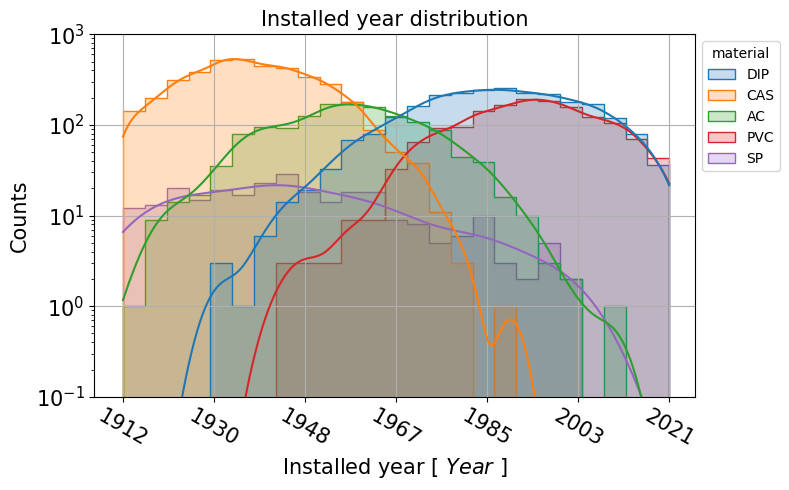

In [364]:
## install year check
min_val = np.nanmin(gm_eda_df['install_time_stamp'])
max_val = np.nanmax(gm_eda_df['install_time_stamp'])
bins = np.linspace(min_val, max_val, 25 + 1)
bin_center = (bins[1:] + bins[:-1]) / 2

## for x tick on the histogram plot
bins_range = np.arange(min_val, max_val + 1, (max_val - min_val) // 6).astype(int) # example timestamp
dt_obj = [datetime.fromtimestamp(bin_r) for bin_r in bins_range] # timestamp to datetime. I didn't consider the timezone
dt_year = [dt.year for dt in dt_obj] # datetime to just year

# plot histogram with KDE
title = 'Installed year distribution'
plt.figure(figsize=(8, 5))
plt.title(title, fontsize = 15)
plt.xlabel(r"Installed year [ $Year$ ]", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xticks(bins_range, dt_year, rotation=-30)
plt.xlim(min_val*1.1, max_val*1.1)
plt.ylim(1e-1, 1e3)
plt.yscale('log')
plt.grid()
ax = sns.histplot(data = gm_eda_df, x= "install_time_stamp", bins = bins, kde = True, hue = "material", element = "step")
#ax = sns.histplot(data = gm_eda_df_new, x= "install_time_date", bins = 50, kde = True, hue = "material", element = "step")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title.replace(' ', '_')
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

In [365]:
gm_time_eda_df[['material']].groupby('material').value_counts().to_frame()

,count
material,
CAS,134
DIP,53
PVC,50
SP,30


# Diameter check

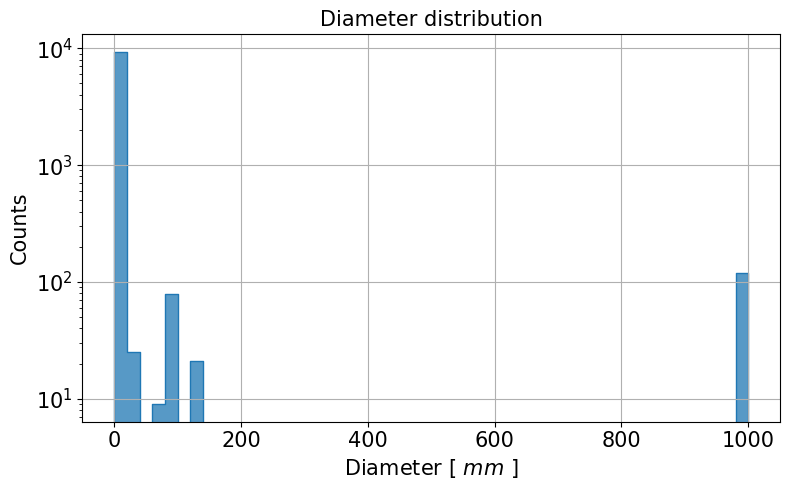

In [366]:
# plot histogram for diameter
bins = np.linspace(0, 1000, 50 + 1)
title = 'Diameter distribution'
plt.figure(figsize=(8, 5))
plt.title(title, fontsize = 15)
plt.xlabel(r"Diameter [ $mm$ ]", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.yscale('log')
plt.grid()
ax = sns.histplot(data = gm_eda_df, x= "diameter", bins = bins, element = "step")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title.replace(' ', '_')
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

In [367]:
gm_eda_df[['diameter']].groupby('diameter').value_counts().to_frame()

,count
diameter,
0.0,173
4.0,1795
6.0,2194
8.0,2028
10.0,1378
12.0,888
14.0,550
16.0,296
24.0,18


In [368]:
## set new diameter column that 0 and 999 mm are nan
gm_eda_df['diameter_new'] = gm_eda_df['diameter'][np.logical_and(gm_eda_df['diameter'] > 1, gm_eda_df['diameter'] < 998)]

## set the new df for missing spot ins the data
gm_dia_eda_df = gm_eda_df[gm_eda_df['diameter_new'].isna()]

# Correlation with missing data columns

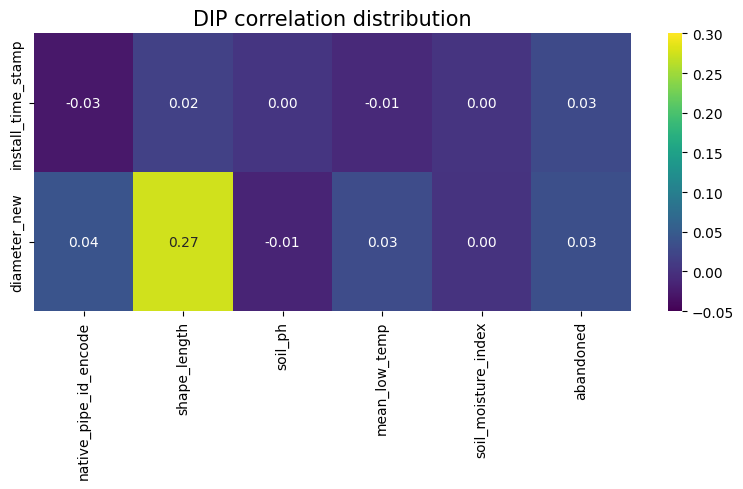

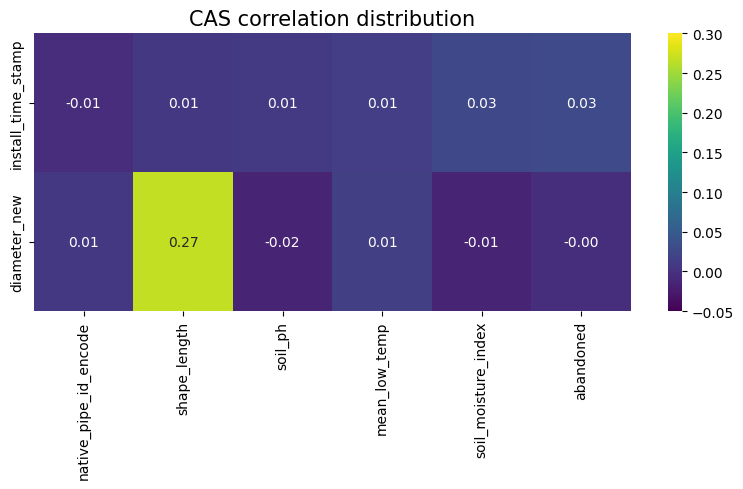

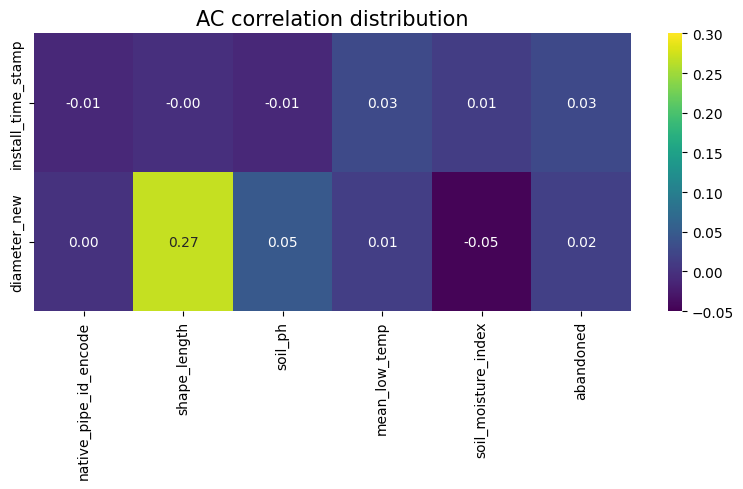

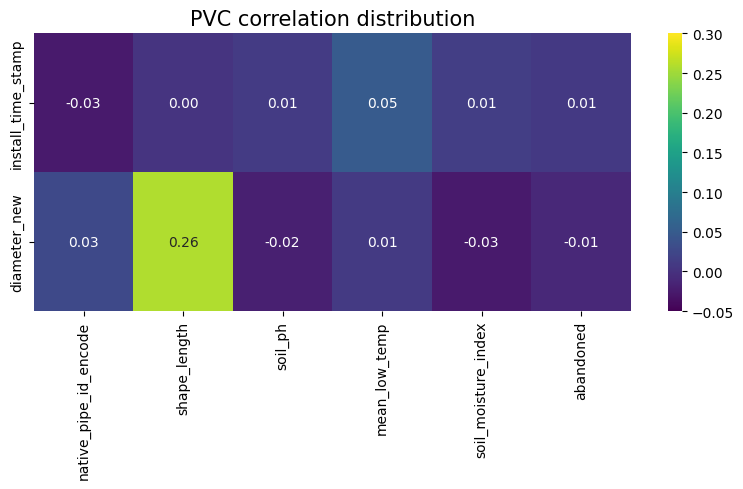

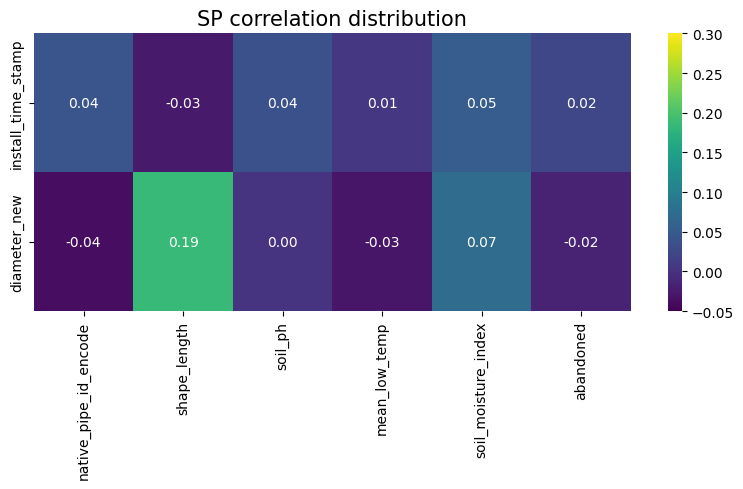

In [369]:
heat_col_list = ['native_pipe_id_encode', 'shape_length', 'soil_ph',
                 'mean_low_temp', 'soil_moisture_index', 'abandoned',
                 'install_time_stamp', 'diameter_new']
gm_heat_df = gm_eda_df[heat_col_list]
for mat in list(gm_eda_df['material'].unique()):

  title = f'{mat} correlation distribution'
  plt.figure(figsize=(8, 5))
  plt.title(title, fontsize = 15)
  sns.heatmap(gm_heat_df[gm_eda_df['material'] == mat].corr().iloc[-2:, :-2], vmin = -0.05, vmax = 0.3, cmap = 'viridis', annot = True, fmt = '.2f')
  #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)
  plt.tight_layout()
  """if not os.path.exists(plot_path):
    os.makedirs(plot_path)
  file_name = title.replace(' ', '_')
  plot_name_path = os.path.join(plot_path,f'{file_name}.png')
  plt.savefig(plot_name_path, bbox_inches = 'tight')"""
  plt.show()
  plt.close()



# Diameter Vs. Shape length

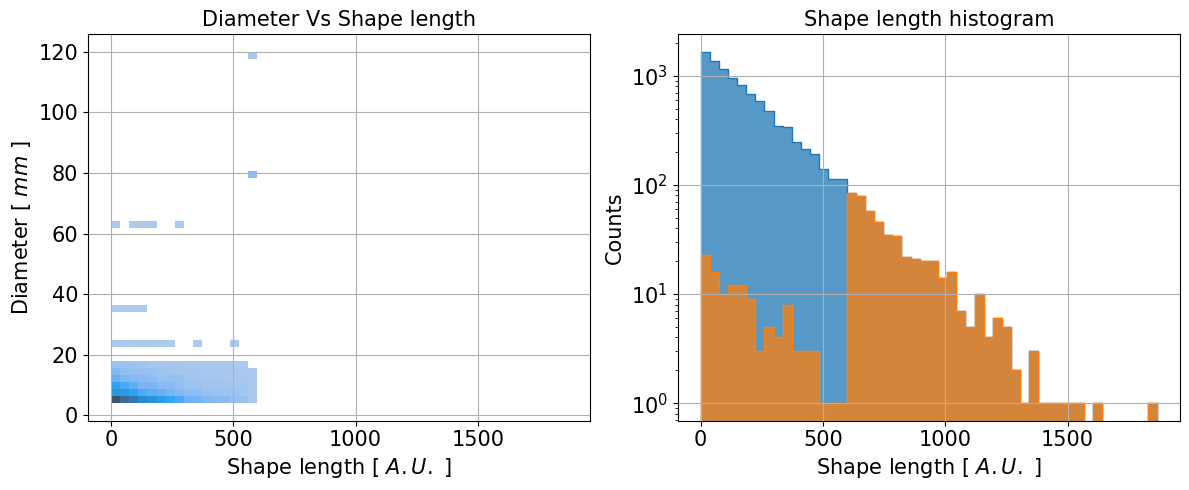

In [370]:
# plot histogram for diameter
dia_bins = np.linspace(np.nanmin(gm_eda_df['diameter_new']), np.nanmax(gm_eda_df['diameter_new']), 50 + 1)
sha_bins = np.linspace(np.nanmin(gm_eda_df['shape_length']), np.nanmax(gm_eda_df['shape_length']), 50 + 1)
title = ['Diameter Vs Shape length', 'Shape length histogram']
xlabel = ['Shape length [ $A.U.$ ]', 'Shape length [ $A.U.$ ]']
ylabel = [r'Diameter [ $mm$ ]', 'Counts']
plt.figure(figsize=(12, 5))

for p in range(2):
  plt.subplot(1, 2, p + 1)
  plt.title(title[p], fontsize = 15)
  plt.xlabel(xlabel[p], fontsize = 15)
  plt.ylabel(ylabel[p], fontsize = 15)
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=15)
  plt.grid()
  if p == 0:
    sns.histplot(data = gm_eda_df, y= "diameter_new", x = 'shape_length', bins = (sha_bins, dia_bins), element = "step")
  else:
    plt.yscale('log')
    sns.histplot(data = gm_eda_df, x= 'shape_length', bins = sha_bins, element = "step")
    sns.histplot(data = gm_dia_eda_df, x= 'shape_length', bins = sha_bins, element = "step")
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title[0].replace(' ', '_')+'_distribution'
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

# WO EDA

In [371]:
gm_eda_df[['native_pipe_id']].groupby('native_pipe_id').value_counts().unique()

array([1, 2, 4, 3])

In [372]:
gm_eda_df.columns

Index(['native_pipe_id', 'material_original', 'install_year_original',
       'shape_length', 'diameter', 'usage_status', 'soil_ph', 'mean_low_temp',
       'soil_moisture_index', 'abandoned', 'material', 'install_year',
       'material_original_encode', 'material_encode', 'native_pipe_id_encode',
       'install_time_stamp', 'diameter_new'],
      dtype='object')

In [373]:
wo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   native_pipe_id              340 non-null    object 
 1   leaking_items_original      333 non-null    object 
 2   repair_results              340 non-null    object 
 3   rminfo                      340 non-null    int64  
 4   receipt_date                311 non-null    float64
 5   registration_date_original  340 non-null    int64  
 6   break_date                  311 non-null    object 
 7   leaking_items               333 non-null    object 
 8   leaking_items_encode        340 non-null    int64  
 9   repair_results_encode       340 non-null    int64  
 10  registration_date           340 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 29.3+ KB


In [482]:
## new df for EDA
wo_eda_df = wo_df.copy()

## Converts 'install_year' to unixtime (timestamp) so that I can it for analysis as a numeric format. I din't consider the timezone
wo_eda_df['break_date_time_stamp'] = wo_eda_df['break_date'].apply(lambda x: pd.to_datetime(x).timestamp() if type(x) != float else np.nan)

## converts np.nan to 'unknown'
wo_eda_df['leaking_items_new'] = wo_eda_df['leaking_items'].apply(lambda x: 'unknown' if type(x) == float else x)
wo_eda_df['leaking_items_encode_new'] = label_encoder.fit_transform(wo_eda_df['leaking_items_new'])

## merge with gm table
"""gm_col_list = ['native_pipe_id', 'shape_length', 'soil_ph', 'mean_low_temp',
               'soil_moisture_index', 'abandoned', 'material', 'install_year',
               'install_time_stamp', 'diameter_new']
wo_eda_df = pd.merge(wo_eda_df, gm_eda_df[gm_col_list], on = 'native_pipe_id', how = 'outer')
wo_eda_df.dropna(subset = 'leaking_items_new', inplace = True)
wo_eda_df.info()"""

"gm_col_list = ['native_pipe_id', 'shape_length', 'soil_ph', 'mean_low_temp',\n               'soil_moisture_index', 'abandoned', 'material', 'install_year',\n               'install_time_stamp', 'diameter_new']\nwo_eda_df = pd.merge(wo_eda_df, gm_eda_df[gm_col_list], on = 'native_pipe_id', how = 'outer')\nwo_eda_df.dropna(subset = 'leaking_items_new', inplace = True)\nwo_eda_df.info()"

In [483]:
gm_col_list = ['native_pipe_id', 'shape_length', 'soil_ph', 'mean_low_temp',
               'soil_moisture_index', 'abandoned', 'material', 'install_year',
               'install_time_stamp', 'diameter_new']
gm_sub_eda_df = gm_eda_df[gm_col_list]
gm_sub_eda_df.dropna(subset = 'install_time_stamp', inplace = True)

wo_sub_eda_df = wo_eda_df.dropna(subset = 'break_date_time_stamp').copy()
wo_sub_eda_df[gm_col_list[1:]] = np.nan
wo_sub_eda_df.reset_index(inplace = True)
for row in tqdm(range(len(wo_sub_eda_df))):
  id_idx = gm_sub_eda_df['native_pipe_id'] == wo_sub_eda_df['native_pipe_id'][row]
  if np.count_nonzero(id_idx) == 0: continue
  gm_ssub_eda_df = gm_sub_eda_df[id_idx]
  diff = wo_sub_eda_df['break_date_time_stamp'][row] - np.asarray(gm_ssub_eda_df['install_time_stamp'])
  diff[diff < 0] = np.nan
  if np.count_nonzero(diff < 0) > 0:
    print(wo_sub_eda_df['break_date'][row], gm_ssub_eda_df['install_year'])
  diff_idx = np.nanargmin(diff)
  wo_sub_eda_df.loc[row, gm_col_list[1:]] = gm_ssub_eda_df.iloc[diff_idx, 1:]
wo_sub_eda_df.dropna(subset = 'install_time_stamp', inplace = True)
wo_sub_eda_df.info()

<ipython-input-483-63e9ac0fb2d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_sub_eda_df.dropna(subset = 'install_time_stamp', inplace = True)
100%|██████████| 311/311 [00:01<00:00, 215.07it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 0 to 310
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       305 non-null    int64  
 1   native_pipe_id              305 non-null    object 
 2   leaking_items_original      298 non-null    object 
 3   repair_results              305 non-null    object 
 4   rminfo                      305 non-null    int64  
 5   receipt_date                305 non-null    float64
 6   registration_date_original  305 non-null    int64  
 7   break_date                  305 non-null    object 
 8   leaking_items               298 non-null    object 
 9   leaking_items_encode        305 non-null    int64  
 10  repair_results_encode       305 non-null    int64  
 11  registration_date           305 non-null    object 
 12  break_date_time_stamp       305 non-null    float64
 13  leaking_items_new           305 non-null

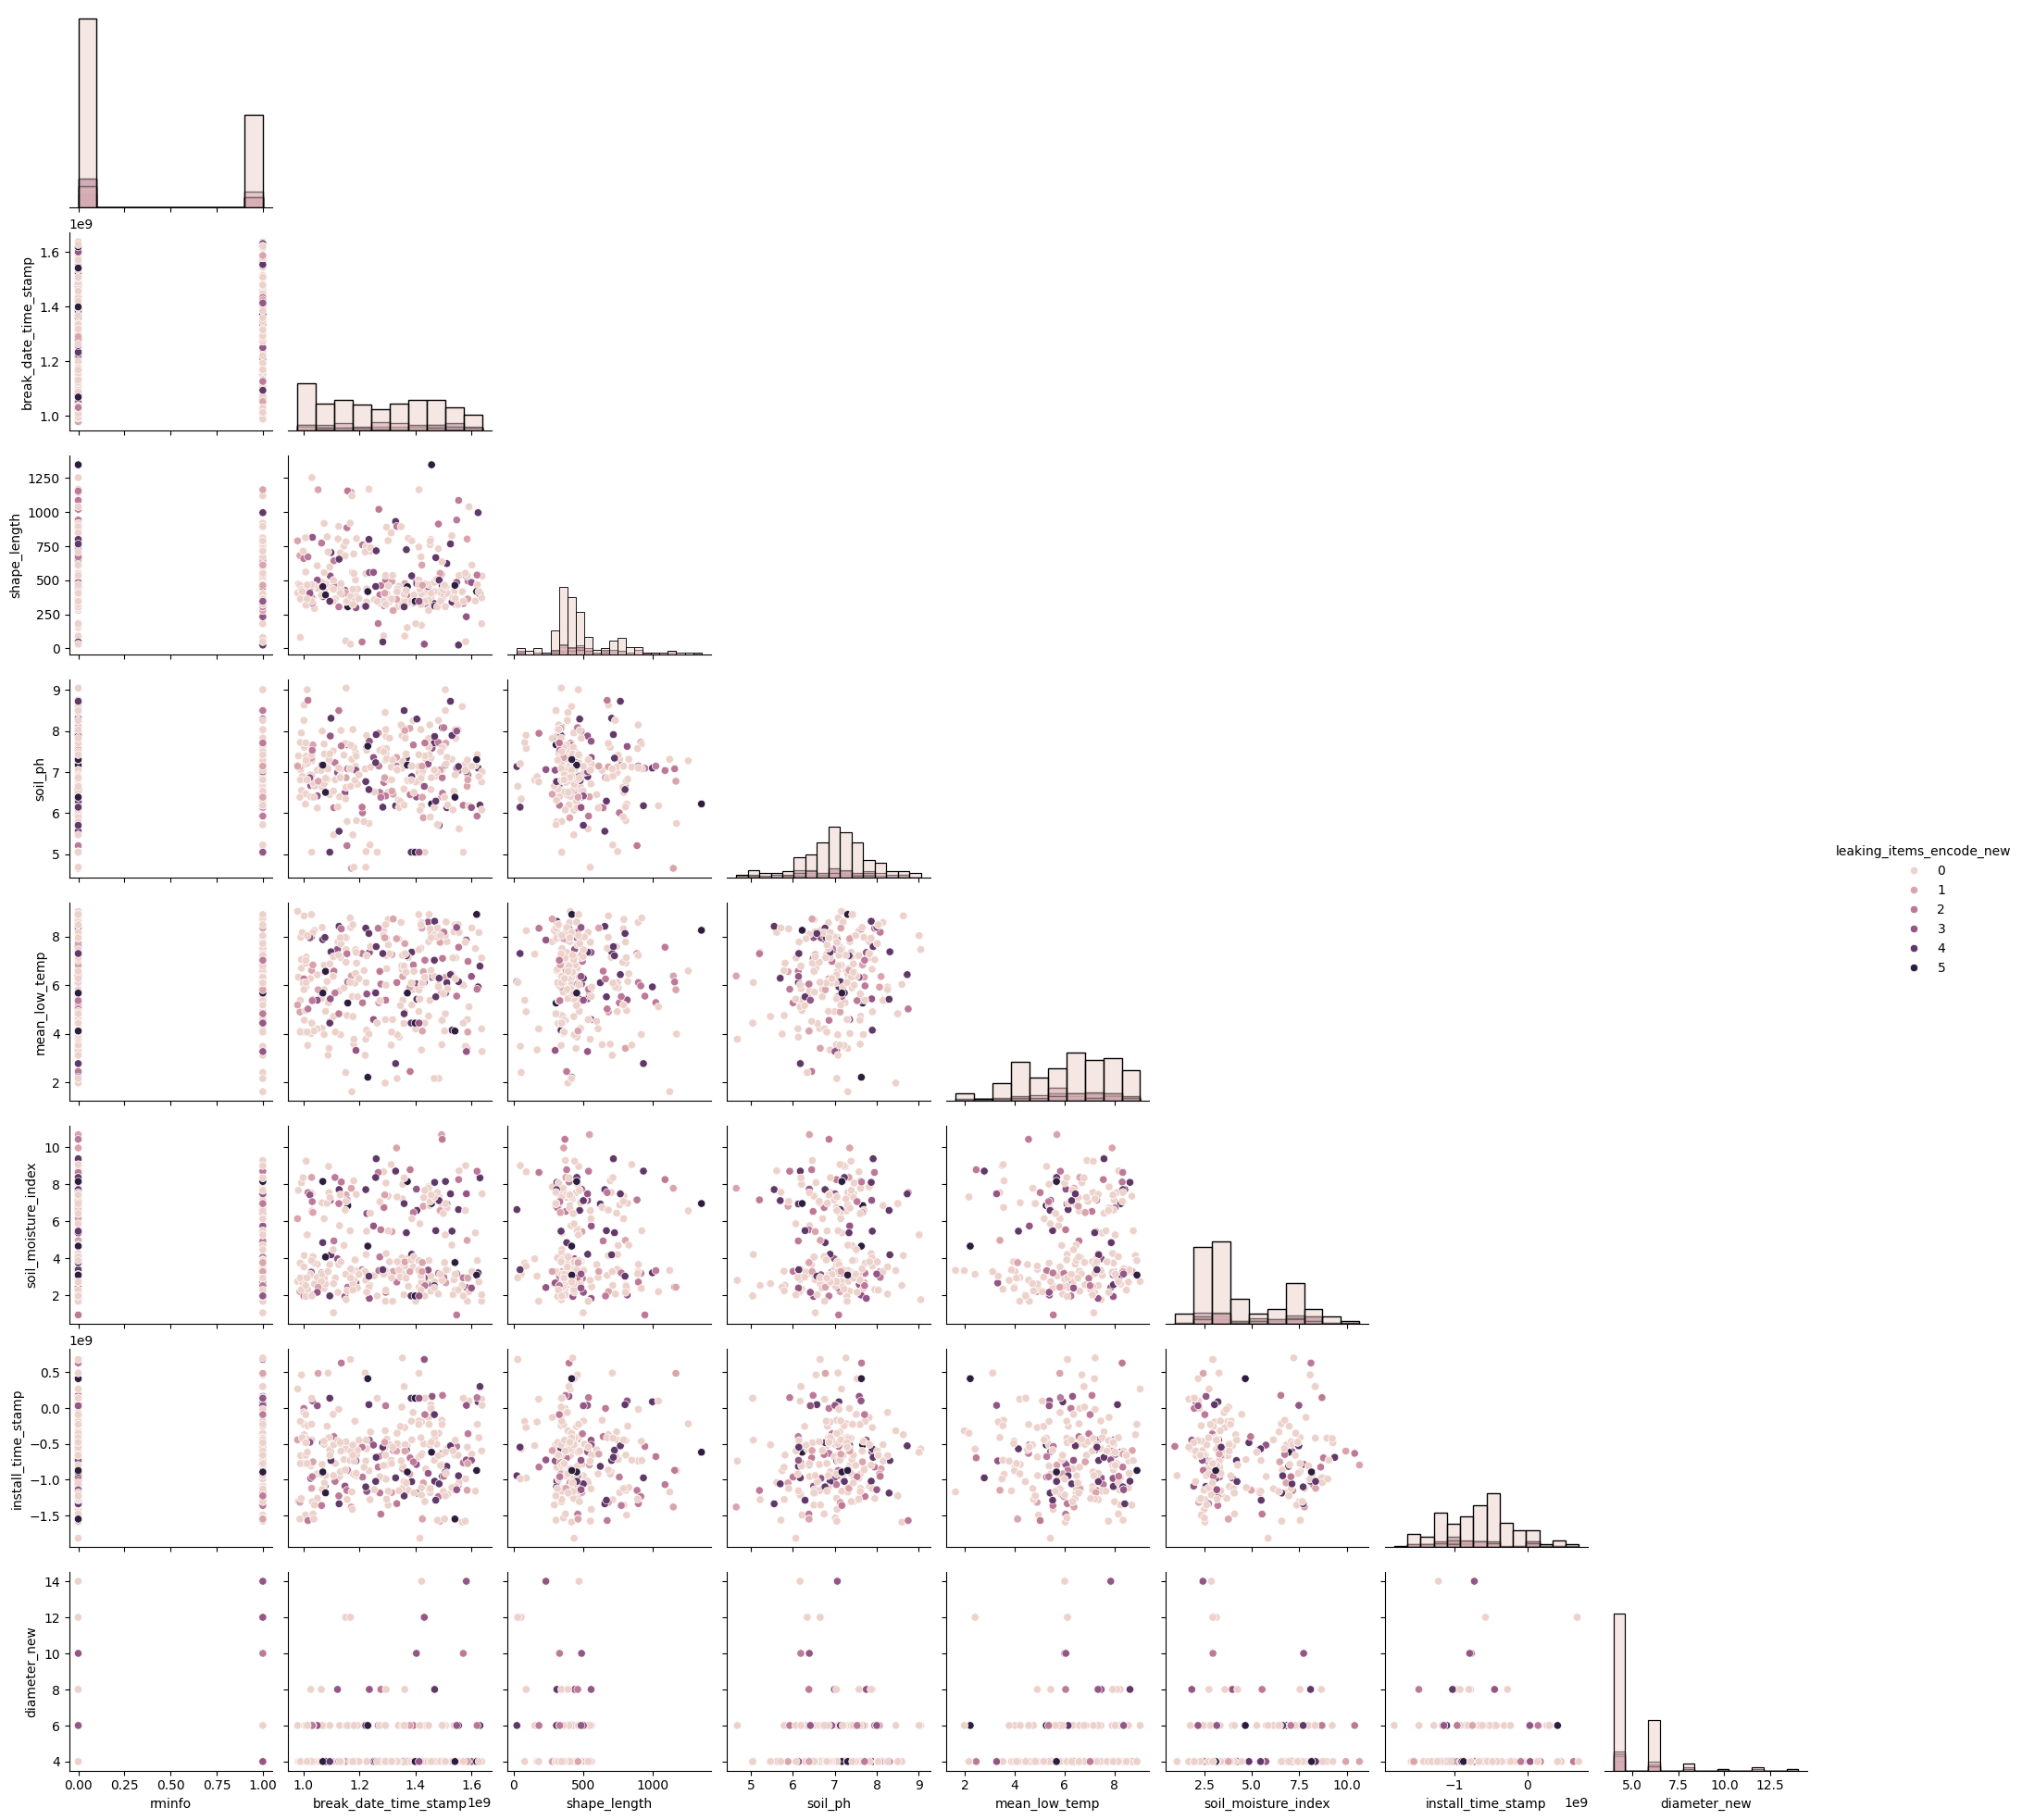

In [522]:
sub_col_list = ['rminfo', 'break_date_time_stamp', 'leaking_items_encode_new', 'shape_length',
                'soil_ph', 'mean_low_temp', 'soil_moisture_index', 'install_time_stamp', 'diameter_new']
sns.pairplot(wo_sub_eda_df[sub_col_list], hue = 'leaking_items_encode_new', diag_kind="hist", corner = True)

In [469]:
wo_sub_eda_df['first_break_time'] = wo_sub_eda_df['break_date_time_stamp'] - wo_sub_eda_df['install_time_stamp']
first_df = wo_sub_eda_df.groupby('native_pipe_id')[['material', 'first_break_time', 'break_date', 'install_year', 'leaking_items_new']].min()
first_df['first_break_time_year'] = pd.to_timedelta(first_df['first_break_time'], unit = 's').dt.days / 365
first_df

,material,first_break_time,break_date,install_year,leaking_items_new,first_break_time_year
native_pipe_id,,,,,,
WM00040-C,CAS,1.894234e+09,2013-06-10,1953-06-01,crack,60.065753
WM00070-A,AC,2.302646e+09,2012-02-17,1939-03-01,third_party_damage,73.016438
WM00118-A,AC,1.627690e+09,2005-11-28,1954-05-01,crack,51.613699
WM00178-C,CAS,1.632874e+09,2013-02-27,1961-06-01,crack,51.778082
WM00269-A,AC,2.097706e+09,2005-07-23,1939-02-01,pinhole_more_than_5mm,66.517808
...,...,...,...,...,...,...
WM14659-A,AC,1.613866e+09,2015-01-21,1963-12-01,crack,51.175342
WM14666-C,CAS,2.092522e+09,2011-01-22,1944-10-01,crack,66.353425
WM14773-C,CAS,2.196288e+09,2016-07-06,1946-12-01,crack,69.643836


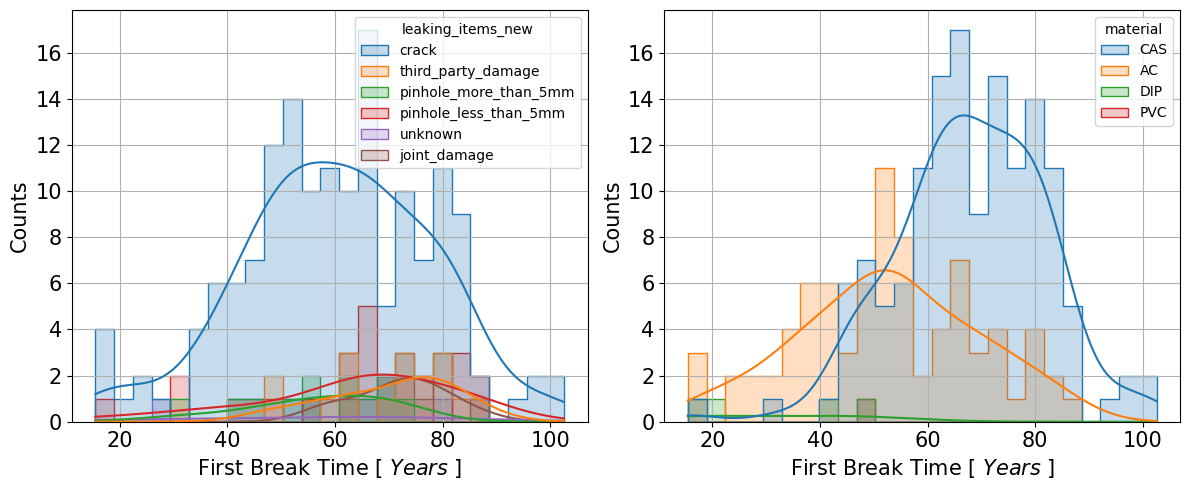

In [481]:
# plot histogram for diameter
fbt_bins = np.linspace(np.nanmin(first_df['first_break_time_year']), np.nanmax(first_df['first_break_time_year']), 25 + 1)
xlabel = ['First Break Time [ $Years$ ]', 'First Break Time [ $Years$ ]']
ylabel = ['Counts', 'Counts']
plt.figure(figsize=(12, 5))

for p in range(2):
  plt.subplot(1, 2, p + 1)
  #plt.title(title[p], fontsize = 15)
  plt.xlabel(xlabel[p], fontsize = 15)
  plt.ylabel(ylabel[p], fontsize = 15)
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=15)
  plt.grid()
  if p == 0:
    sns.histplot(data = first_df, x= 'first_break_time_year', kde = True, bins = fbt_bins, hue = 'leaking_items_new', element = "step")
  else:
    sns.histplot(data = first_df, x= 'first_break_time_year', kde = True, bins = fbt_bins, hue = 'material', element = "step")
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = 'First_break_time_distribution'
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

In [508]:
wo_sub_eda_df2 = wo_eda_df.dropna(subset = 'break_date_time_stamp').copy()
wo_sub_eda_df2.reset_index(inplace = True)
cause_item = []
between_break = []
for row in range(len(wo_sub_eda_df2['native_pipe_id'].unique())):
  #if row != 5: continue
  id_idx = wo_sub_eda_df2['native_pipe_id'] == wo_sub_eda_df2['native_pipe_id'][row]
  if np.count_nonzero(id_idx) > 1:
    indi_df = wo_sub_eda_df2[['leaking_items_new', 'break_date_time_stamp']][id_idx].sort_values('break_date_time_stamp')
    cause_item += list(indi_df['leaking_items_new'][1:])
    time_np = np.asarray(indi_df['break_date_time_stamp'])
    between_break = np.concatenate((between_break, np.diff(time_np)))

wo_sub_eda_df3 = pd.DataFrame({'cause_item': cause_item, 'between_break': between_break})
wo_sub_eda_df3['between_break_year'] = pd.to_timedelta(wo_sub_eda_df3['between_break'], unit = 's').dt.days / 365

,cause_item,between_break,between_break_year
0,pinhole_less_than_5mm,4924800.0,0.156164
1,crack,42163200.0,1.336986
2,pinhole_less_than_5mm,193795200.0,6.145205
3,crack,121996800.0,3.868493
4,crack,221184000.0,7.013699
...,...,...,...
80,crack,42163200.0,1.336986
81,pinhole_less_than_5mm,193795200.0,6.145205
82,crack,121996800.0,3.868493
83,crack,221184000.0,7.013699


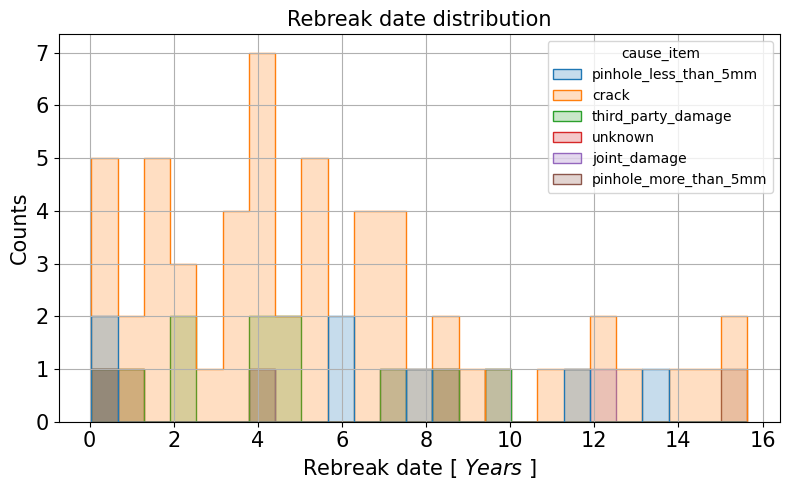

In [512]:
# plot histogram for diameter
fbt_bins = np.linspace(np.nanmin(wo_sub_eda_df3['between_break_year']), np.nanmax(wo_sub_eda_df3['between_break_year']), 25 + 1)
title = 'Rebreak date distribution'
plt.figure(figsize=(8, 5))
plt.title(title, fontsize = 15)
plt.xlabel(r"Rebreak date [ $Years$ ]", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
#plt.yscale('log')
plt.grid()
ax = sns.histplot(data = wo_sub_eda_df3, x= "between_break_year", bins = fbt_bins, hue = 'cause_item', element = "step")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title.replace(' ', '_')
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

In [396]:
g_idx = wo_eda_df.groupby('native_pipe_id')['native_pipe_id'].count().sort_values(ascending = False)
print(g_idx)
#g_id_name = g_idx.index[np.nanargmax(g_idx)]
#gmwo_eda_df[(gmwo_eda_df['native_pipe_id'] == g_id_name) & (gmwo_eda_df['install_year'] == '1945-07-01')].sort_values(by = 'break_date')
wo_eda_df[(wo_eda_df['native_pipe_id'] == g_idx.index[3])].sort_values('install_year').sort_values('break_date')[['native_pipe_id', 'break_date', 'install_year']]

native_pipe_id
WM09505-C    12
WM06341-C    10
WM11821-A     8
WM06832-D     6
WM07050-C     6
             ..
WM08891-C     1
WM08939-A     1
WM08946-C     1
WM08964-C     1
WM04744-A     1
Name: native_pipe_id, Length: 246, dtype: int64


,native_pipe_id,leaking_items_original,repair_results,rminfo,receipt_date,registration_date_original,break_date,leaking_items,leaking_items_encode,repair_results_encode,...,leaking_items_encode_new,shape_length,soil_ph,mean_low_temp,soil_moisture_index,abandoned,material,install_year,install_time_stamp,diameter_new
215,WM06832-D,亀裂,Resolved,0.0,20070110.0,20221114.0,2007-01-10,crack,0.0,0.0,...,0.0,363.959548,6.815418,7.829311,2.725479,False,CAS,1941-08-01,-896832000.0,4.0
216,WM06832-D,亀裂,Resolved,0.0,20070110.0,20221114.0,2007-01-10,crack,0.0,0.0,...,0.0,31.113610,6.651073,6.114272,2.947931,False,DIP,1991-08-01,681004800.0,12.0
211,WM06832-D,ピンホール（5mm以上）,Resolved,1.0,20150517.0,20221114.0,2015-05-17,pinhole_more_than_5mm,3.0,0.0,...,3.0,363.959548,6.815418,7.829311,2.725479,False,CAS,1941-08-01,-896832000.0,4.0
212,WM06832-D,ピンホール（5mm以上）,Resolved,1.0,20150517.0,20221114.0,2015-05-17,pinhole_more_than_5mm,3.0,0.0,...,3.0,31.113610,6.651073,6.114272,2.947931,False,DIP,1991-08-01,681004800.0,12.0
213,WM06832-D,ピンホール（5mm以下）,Resolved,0.0,NaN,20221114.0,NaN,pinhole_less_than_5mm,2.0,0.0,...,2.0,363.959548,6.815418,7.829311,2.725479,False,CAS,1941-08-01,-896832000.0,4.0
214,WM06832-D,ピンホール（5mm以下）,Resolved,0.0,NaN,20221114.0,NaN,pinhole_less_than_5mm,2.0,0.0,...,2.0,31.113610,6.651073,6.114272,2.947931,False,DIP,1991-08-01,681004800.0,12.0


In [383]:
df = pd.DataFrame({"name": ['Alfred', 'Batman', 'Catwoman'],
                   "toy": [np.nan, 'Batmobile', 'Bullwhip'],
                   "born": [pd.NaT, pd.Timestamp("1940-04-25"),
                            pd.NaT]})
df

,name,toy,born
0,Alfred,NaN,NaT
1,Batman,Batmobile,1940-04-25
2,Catwoman,Bullwhip,NaT


In [387]:
df.dropna(subset='born')

,name,toy,born
1,Batman,Batmobile,1940-04-25


In [156]:
name = 'shape_length'
min_val = np.nanmin(gm_eda_df[name])
max_val = np.nanmax(gm_eda_df[name])
bins = np.linspace(min_val, max_val, 25 + 1)
name2 = 'install_time_stamp'
dia_bins = np.linspace(np.nanmin(gm_eda_df[name2]), np.nanmax(gm_eda_df[name2]), 25 + 1)


"plt.tight_layout()\nif not os.path.exists(plot_path):\n  os.makedirs(plot_path)\nfile_name = title.replace(' ', '_')\nplot_name_path = os.path.join(plot_path,f'{file_name}.png')\nplt.savefig(plot_name_path, bbox_inches = 'tight')\nplt.show()\nplt.close()"

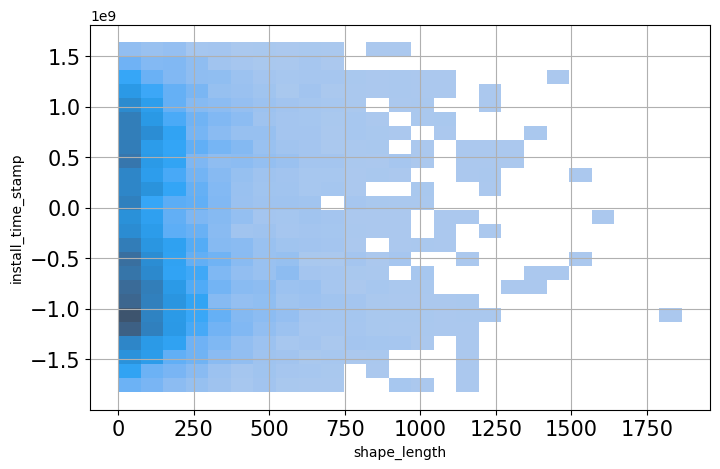

In [158]:
# plot histogram with KDE
#title = 'Installed year distribution'
plt.figure(figsize=(8, 5))
#plt.title(title, fontsize = 15)
#plt.xlabel(r"Installed year [ $Year$ ]", fontsize = 15)
#plt.ylabel("Counts", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
#plt.xlim(min_val*1.1, max_val*1.1)
#plt.ylim(1e-1, 1e3)
#plt.yscale('log')
plt.grid()
ax = sns.histplot(data = gm_eda_df, x= name, y = name2, bins = (bins, dia_bins), element = "step")#, hue = "material")
#ax = sns.histplot(data = gm_eda_df, x= name, bins = bins, hue = "material", element = "step")
#ax = sns.histplot(data = gm_eda_df_new, x= "install_time_date", bins = 50, kde = True, hue = "material", element = "step")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
"""plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title.replace(' ', '_')
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()"""

'plt.legend(loc="best", fontsize = 15)\nif not os.path.exists(plot_path):\n    os.makedirs(plot_path)\nplot_name = f\'ROC_curve\'\nplot_name_path = os.path.join(plot_path,f\'{plot_name}.png\')\nplt.savefig(plot_name_path, bbox_inches = \'tight\')\nplt.show()'

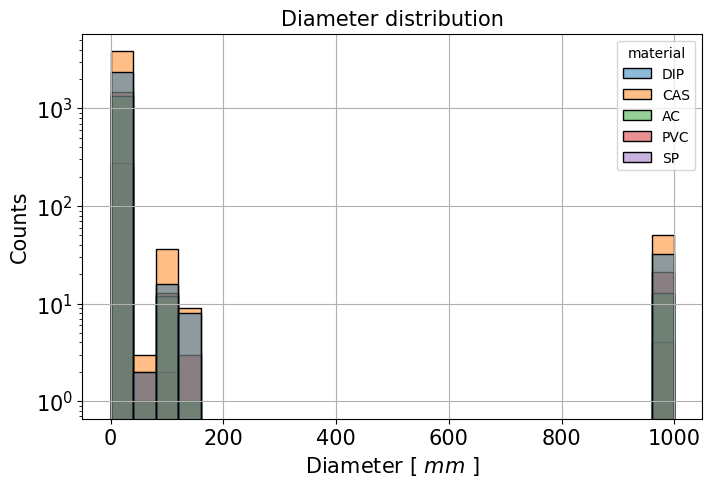

In [ ]:


plt.figure(figsize=(8, 5))
plt.title("Diameter distribution", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel(r"Diameter [ $mm$ ]", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.yscale('log')
plt.grid()
#gm_df['diameter'].hist(bins = np.linspace(0, 1000, 25 + 1))
sns.histplot(data = gm_df, x= r"diameter", bins = np.linspace(0, 1000, 25 + 1), hue = "material")


"""plt.figure(figsize=(8, 5))
plt.title("Diameter distribution", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel(r"Diameter [ $mm$ ]", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.yscale('log')
gm_df['diameter'].hist(bins = np.linspace(0, 1000, 25 + 1))"""

"""plt.legend(loc="best", fontsize = 15)
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plot_name = f'ROC_curve'
plot_name_path = os.path.join(plot_path,f'{plot_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()"""


In [ ]:
## new dfs for EDA
#gm_col_list = ['native_pipe_id', 'material_original', 'material', 'shape_length',
gm_col_list = ['native_pipe_id', 'material_original_encode', 'material_encode', 'shape_length',
               'soil_ph', 'mean_low_temp', 'soil_moisture_index', 'abandoned',
               'install_year', 'diameter']
gm_eda_df = gm_df[gm_col_list]
gm_eda_df['native_pipe_id_encode'] = label_encoder.fit_transform(gm_eda_df['native_pipe_id'])
gm_eda_df['install_year'] = gm_eda_df['install_year'].apply(lambda x: pd.to_datetime(x) if type(x) != float else np.nan)
#wo_col_list = ['native_pipe_id', 'rminfo', 'break_date', 'leaking_items']
wo_col_list = ['native_pipe_id', 'rminfo', 'break_date', 'leaking_items_encode']
wo_eda_df = wo_df[wo_col_list]
wo_eda_df['break_date'] = wo_eda_df['break_date'].apply(lambda x: pd.to_datetime(x) if type(x) != float else np.nan)


print(gm_eda_df.shape, wo_eda_df.shape)

gmwo_eda_df = pd.merge(gm_eda_df, wo_eda_df, on = 'native_pipe_id', how = 'outer') # The outer for accommodating all possible 'install_year' and 'break_date' pairs
gmwo_eda_df['date_diff'] = gmwo_eda_df['break_date'] - gmwo_eda_df['install_year']
print(gmwo_eda_df.shape)

gmwo_eda_df.info()

<ipython-input-41-1cb0c5c5cac4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_eda_df['native_pipe_id_encode'] = label_encoder.fit_transform(gm_eda_df['native_pipe_id'])


(9876, 11) (340, 4)
(9988, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   native_pipe_id            9988 non-null   object         
 1   material_original_encode  9988 non-null   int64          
 2   material_encode           9988 non-null   int64          
 3   shape_length              9988 non-null   float64        
 4   soil_ph                   9988 non-null   float64        
 5   mean_low_temp             9988 non-null   float64        
 6   soil_moisture_index       9988 non-null   float64        
 7   abandoned                 9988 non-null   bool           
 8   install_year              9719 non-null   datetime64[ns] 
 9   diameter                  9662 non-null   float64        
 10  native_pipe_id_encode     9988 non-null   int64          
 11  rminfo                    403 non-null

<ipython-input-41-1cb0c5c5cac4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_eda_df['install_year'] = gm_eda_df['install_year'].apply(lambda x: pd.to_datetime(x) if type(x) != float else np.nan)
<ipython-input-41-1cb0c5c5cac4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_eda_df['break_date'] = wo_eda_df['break_date'].apply(lambda x: pd.to_datetime(x) if type(x) != float else np.nan)


<Axes: >

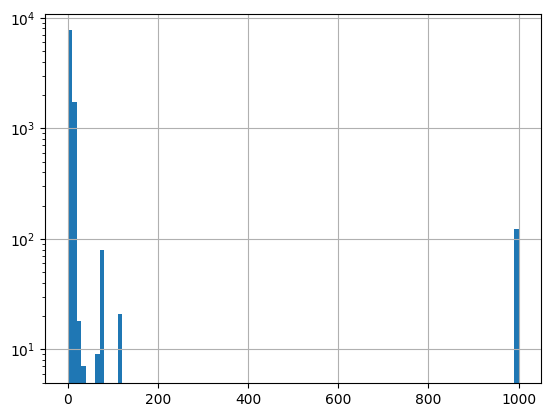

In [ ]:
plt.yscale('log')
gmwo_eda_df['diameter'].hist(bins = np.linspace(0,1000,100))

In [ ]:
gmwo_eda_df['date_diff'].unique()

<TimedeltaArray>
[         NaT, '26977 days', '21467 days', '27070 days', '17761 days',
 '28619 days', '21924 days', '25162 days', '27779 days', '22335 days',
 ...
 '14748 days', '13016 days', '20282 days', '18539 days', '29422 days',
 '23605 days', '25533 days', '31091 days', '35228 days', '22366 days']
Length: 361, dtype: timedelta64[ns]

<Axes: >

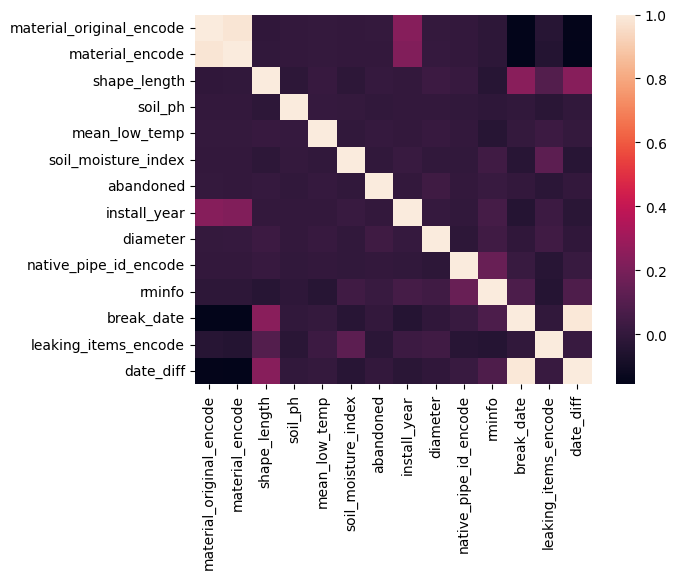

In [ ]:
sns.heatmap(gmwo_eda_df[gmwo_eda_df.columns[1:]].corr())

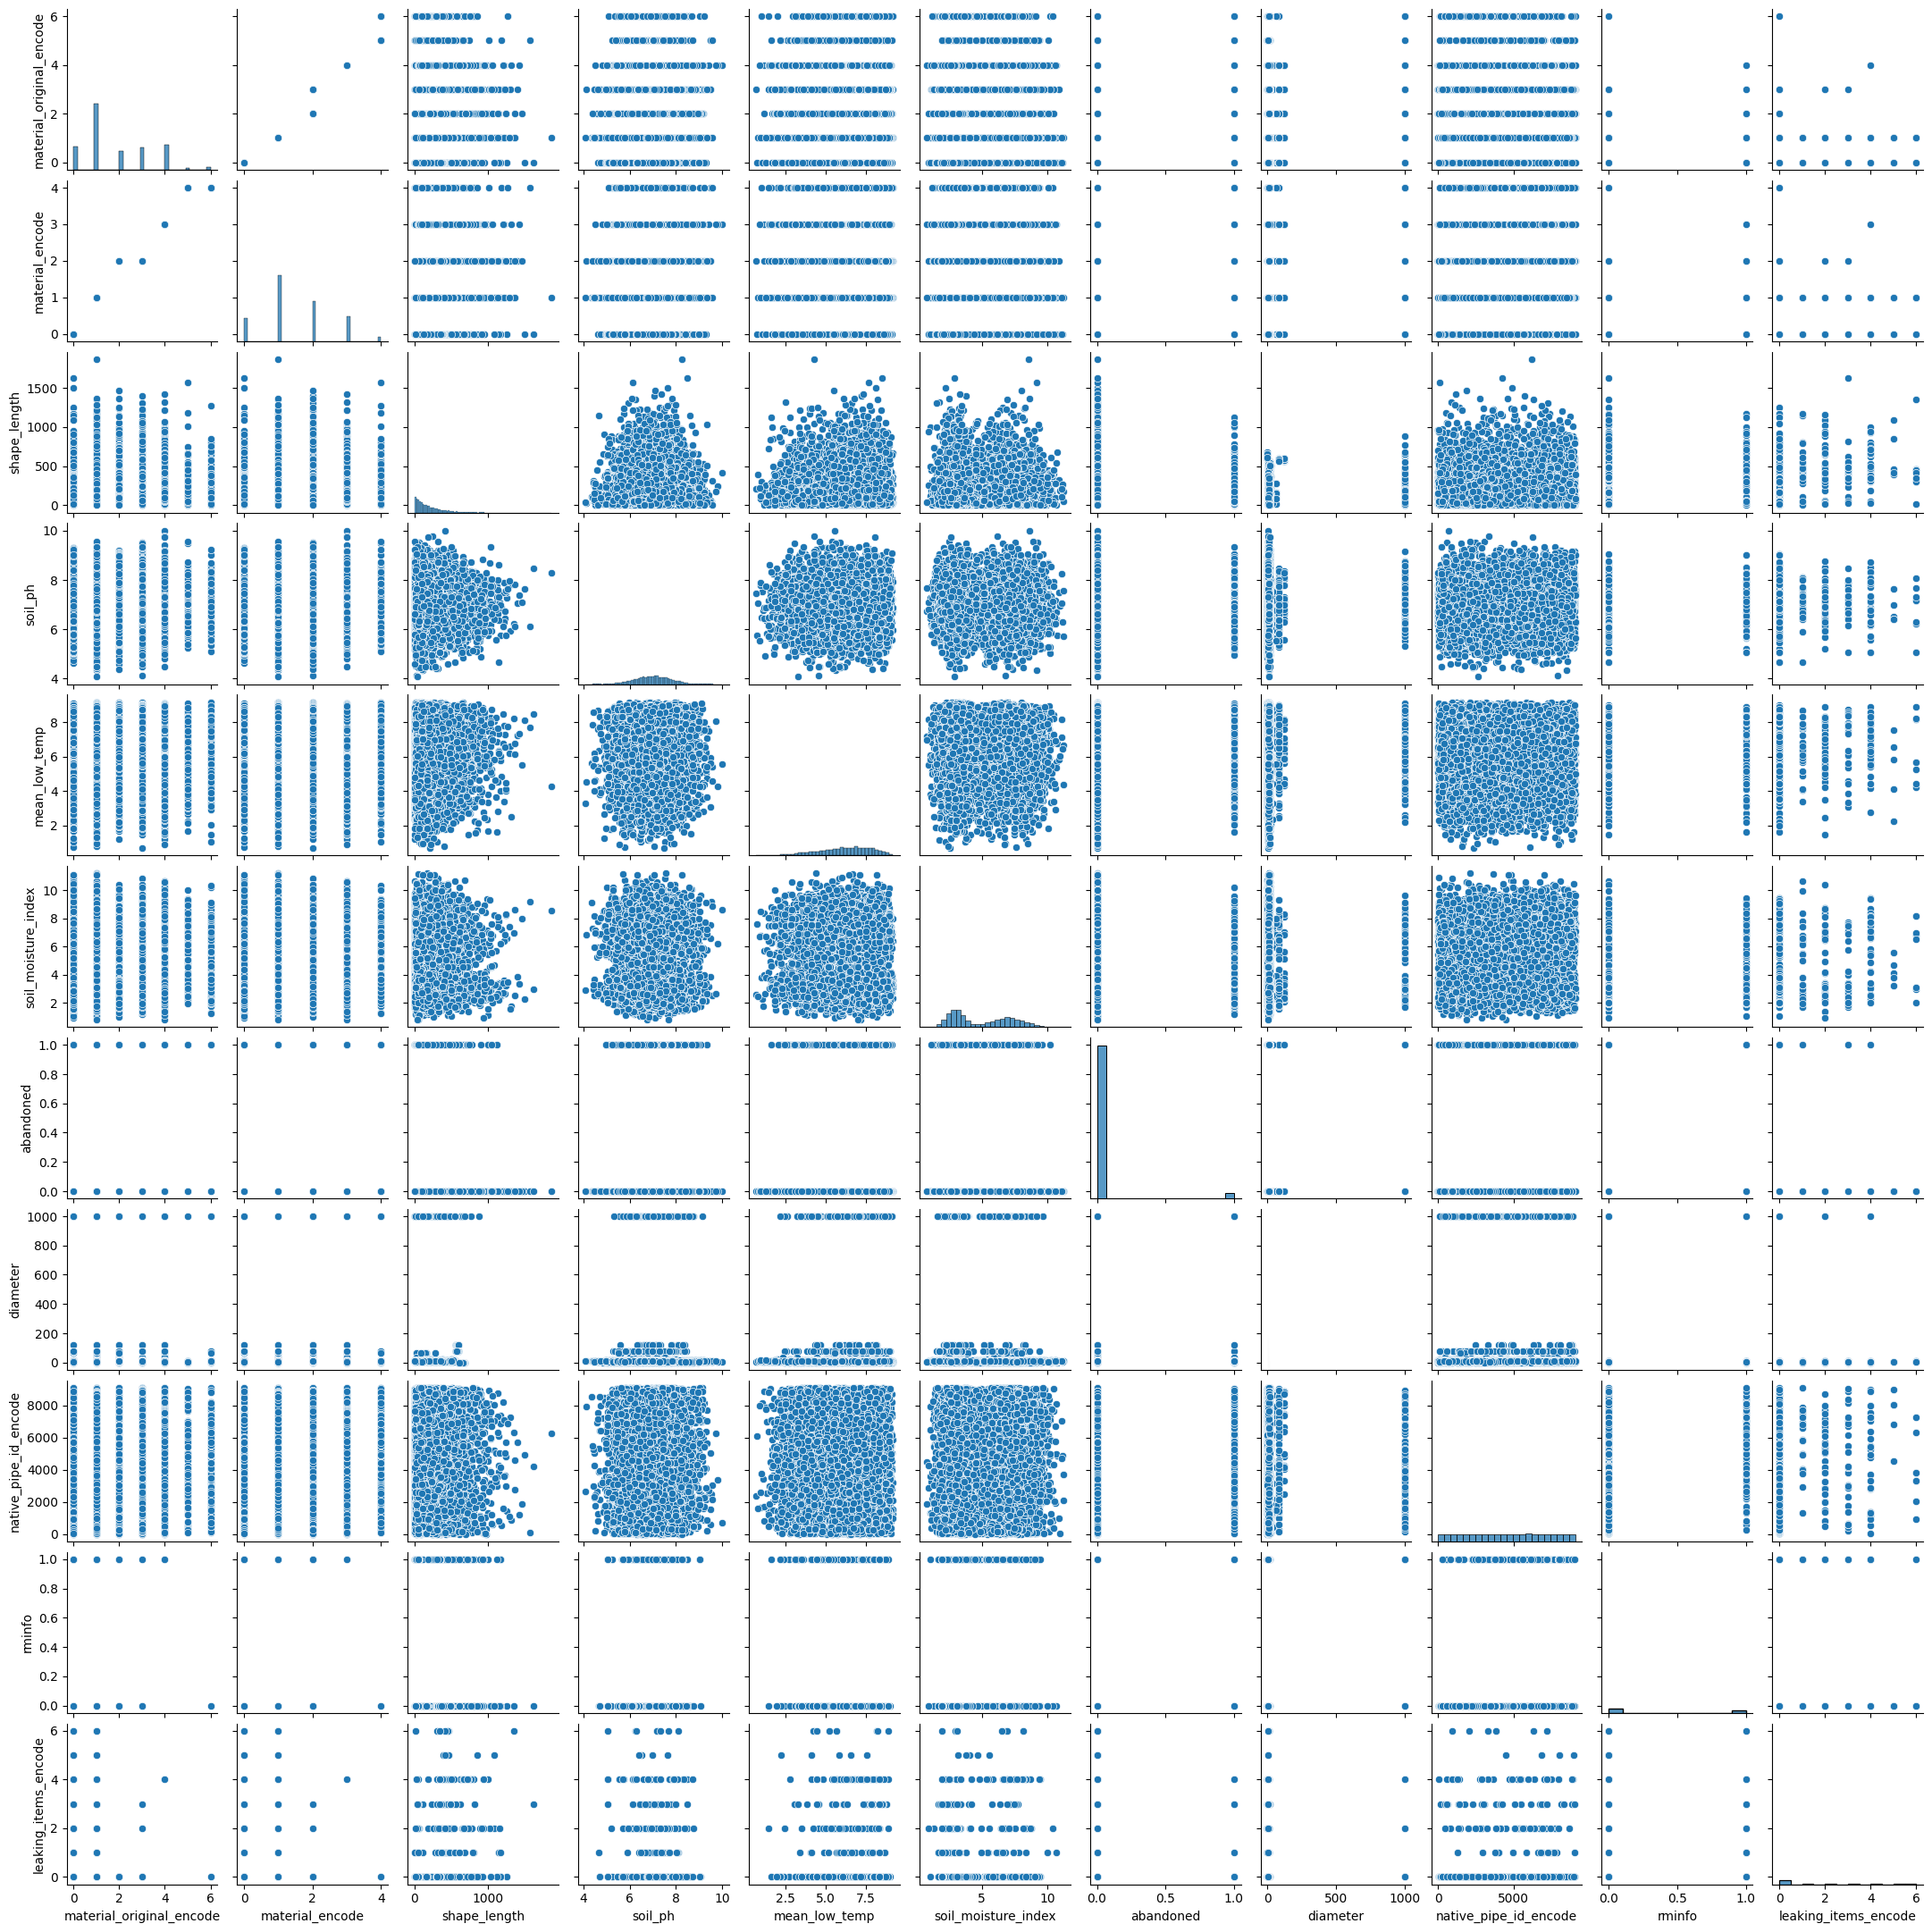

In [ ]:
sns.pairplot(gmwo_eda_df[gmwo_eda_df.columns[1:]], height = 2)#, hue = 'date_diff', plot_kws={'legend': False})

In [ ]:
3gm_id = gm_eda_df['native_pipe_id'].to_numpy(dtype = 'object')
wo_id = wo_eda_df['native_pipe_id'].to_numpy(dtype = 'object')
idxs = np.in1d(wo_id, gm_id)
print(idxs.sum())


340


In [ ]:
#g_name = gmwo_eda_df[['native_pipe_id']].groupby('native_pipe_id').count()
g_idx = gmwo_eda_df.groupby('native_pipe_id')['native_pipe_id'].count().sort_values(ascending = False)
print(g_idx)
#g_id_name = g_idx.index[np.nanargmax(g_idx)]
#gmwo_eda_df[(gmwo_eda_df['native_pipe_id'] == g_id_name) & (gmwo_eda_df['install_year'] == '1945-07-01')].sort_values(by = 'break_date')
gmwo_eda_df[(gmwo_eda_df['native_pipe_id'] == g_idx.index[33])].sort_values('break_date').sort_values('install_year')

native_pipe_id
WM09505-C    12
WM06341-C    10
WM11821-A     8
WM07050-C     6
WM06832-D     6
             ..
WM05297-P     1
WM05297-D     1
WM05294-L     1
WM05293-D     1
WM14875-D     1
Name: native_pipe_id, Length: 9104, dtype: int64


,native_pipe_id,material_original,material,shape_length,soil_ph,mean_low_temp,soil_moisture_index,abandoned,install_year,diameter,rminfo,break_date,leaking_items
3958,WM01194-C,CIP,CAS,64.023228,7.490366,3.486759,3.342955,False,1938-06-01,6.0,NaN,NaN,NaN
3959,WM01194-C,CIP,CAS,117.007968,5.834322,8.925871,2.173715,False,1941-12-01,6.0,NaN,NaN,NaN
3960,WM01194-C,CIP,CAS,224.607740,7.747828,8.081533,7.361222,False,1952-10-01,14.0,NaN,NaN,NaN


In [ ]:
b_unix = gmwo_eda_df['break_date'].apply(lambda x: pd.to_datetime(x).timestamp() if type(x) != float else np.nan)
i_unix = gmwo_eda_df['install_year'].apply(lambda x: pd.to_datetime(x).timestamp() if type(x) != float else np.nan)
i_unix

0       5.653152e+08
1      -5.208192e+08
2      -1.104538e+09
3      -4.154976e+08
4       2.866752e+08
            ...     
9983    2.497824e+08
9984   -5.865696e+08
9985    9.939456e+08
9986   -1.669853e+09
9987   -7.390656e+08
Name: install_year, Length: 9988, dtype: float64

In [ ]:
print(np.nansum((b_unix - i_unix) <= 0))

1


In [ ]:
np.char.join(' - ', 'osd')

array('o - s - d', dtype='<U9')

In [ ]:
np.char.replace(np.asarray(gm_df['install_year_original'], dtype = str), '.', '-')

array(['S63-12', 'S29-7', 'S11-1', ..., 'H14-7', 'T7-2', 'S22-8'],
      dtype='<U6')

In [ ]:
gm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   native_pipe_id         9876 non-null   object 
 1   material_original      9876 non-null   object 
 2   install_year_original  9609 non-null   object 
 3   shape_length           9876 non-null   float64
 4   diameter               9556 non-null   float64
 5   usage_status           9876 non-null   bool   
 6   soil_ph                9876 non-null   float64
 7   mean_low_temp          9876 non-null   float64
 8   soil_moisture_index    9876 non-null   float64
 9   abandoned              9876 non-null   bool   
 10  material               9876 non-null   object 
 11  install_year           9876 non-null   object 
dtypes: bool(2), float64(5), object(5)
memory usage: 791.0+ KB


In [ ]:
!pip install Japanera

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/util

In [ ]:
gm_df['install_year'][0]

'1987-12-01'

In [ ]:
from japanera import EraDate

# The library outputs dates corresponding to all eras starting with "H",
# as it's somewhat ambiguous which is being referred to
date_candidates = EraDate.strptime('S63.12', '%-h%-y.%m')
date_candidates
# Use max(), with the assumption that the most recent era is the correct one
#max(date_candidates)

[EraDate(63, 12, 1, Era('西暦', 'Seireki', datetime.date(1, 1, 1), None, <EraType.COMMON: 'common'>)),
 EraDate(1988, 12, 1, Era('昭和', 'Shouwa', datetime.date(1926, 12, 25), datetime.date(1989, 1, 8), <EraType.GENERAL: 'general'>))]

In [ ]:
import datetime as dt
def parse_heisei(date_string, sep='.'):
    y, m, d = date_string.split(sep)
    return dt.date(year=1989 + int(y[1:]) - 1, month=int(m), day=int(d))
gm_df.head()

,native_pipe_id,material_original,install_year_original,shape_length,diameter,usage_status,soil_ph,mean_low_temp,soil_moisture_index,abandoned,material,install_year
0,WM09952-D,DUC(K),S63.12,24.618317,10.0,True,7.607464,4.924143,6.355882,False,DIP,1987-12-01
1,WM02595-P,CIP,S29.7,514.015780,10.0,True,7.998868,5.738295,7.589341,False,CAS,1953-07-01
2,WM04638-C,CIP,S11.1,447.747983,6.0,True,8.278671,5.193168,5.677802,False,CAS,1935-01-01
3,WM02974-D,DUC(G),S55.2,120.438646,14.0,True,6.409756,6.154922,3.547069,False,DIP,1979-02-01
4,WM08449-D,DUC(K),H28.9,0.018670,10.0,True,7.114687,8.418888,4.167609,False,DIP,2015-09-01


In [ ]:
import datetime

In [ ]:
datetime.date(1988, 12, 1)

datetime.date(1988, 12, 1)

In [ ]:
gm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   native_pipe_id         9876 non-null   object 
 1   material_original      9876 non-null   object 
 2   install_year_original  9609 non-null   object 
 3   shape_length           9876 non-null   float64
 4   diameter               9556 non-null   float64
 5   usage_status           9876 non-null   bool   
 6   soil_ph                9876 non-null   float64
 7   mean_low_temp          9876 non-null   float64
 8   soil_moisture_index    9876 non-null   float64
 9   abandoned              9876 non-null   bool   
 10  material               9876 non-null   object 
 11  install_year           9876 non-null   object 
dtypes: bool(2), float64(5), object(5)
memory usage: 791.0+ KB
